In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definindo os parâmetros de plotagem das figuras
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

# Mostrar floats com duas casas decimas
pd.set_option('display.float_format',  lambda x: '%.4g' % x)
pd.options.display.max_colwidth = 20
pd.options.display.max_columns = 20
pd.options.display.max_rows = 6

In [2]:
# Load magic stocks prices
df_stocks = pd.read_csv(
    "../data/adjusted_prices.csv", parse_dates=['datneg', 'cutoff_date', 'next_cutoff'])
df_stocks

,datneg,codneg,nomres,preult,premed,cutoff_date,next_cutoff
0,2016-04-11,AGRO3,BRASILAGRO,7.905,7.856,2016-04-11,2017-04-10
1,2016-04-12,AGRO3,BRASILAGRO,7.905,7.863,2016-04-11,2017-04-10
2,2016-04-13,AGRO3,BRASILAGRO,8.015,7.905,2016-04-11,2017-04-10
...,...,...,...,...,...,...,...
82380,2021-04-08,YDUQ3,YDUQS PART,30.28,29.8,2020-04-09,2021-04-12
82381,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12
82382,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12


In [3]:
# Create a column with the first price of the stock for each interval
df_stocks['first_value'] = df_stocks.groupby(
    by=['codneg', 'cutoff_date'])['premed'].transform('first')
df_stocks

,datneg,codneg,nomres,preult,premed,cutoff_date,next_cutoff,first_value
0,2016-04-11,AGRO3,BRASILAGRO,7.905,7.856,2016-04-11,2017-04-10,7.856
1,2016-04-12,AGRO3,BRASILAGRO,7.905,7.863,2016-04-11,2017-04-10,7.856
2,2016-04-13,AGRO3,BRASILAGRO,8.015,7.905,2016-04-11,2017-04-10,7.856
...,...,...,...,...,...,...,...,...
82380,2021-04-08,YDUQ3,YDUQS PART,30.28,29.8,2020-04-09,2021-04-12,26.16
82381,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12,26.16
82382,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12,26.16


In [4]:
# Normalize values with the first price of the stock for in each period
df_stocks['price_n'] = 100 * df_stocks['premed'] / df_stocks['first_value']
df_stocks

,datneg,codneg,nomres,preult,premed,cutoff_date,next_cutoff,first_value,price_n
0,2016-04-11,AGRO3,BRASILAGRO,7.905,7.856,2016-04-11,2017-04-10,7.856,100
1,2016-04-12,AGRO3,BRASILAGRO,7.905,7.863,2016-04-11,2017-04-10,7.856,100.1
2,2016-04-13,AGRO3,BRASILAGRO,8.015,7.905,2016-04-11,2017-04-10,7.856,100.6
...,...,...,...,...,...,...,...,...,...
82380,2021-04-08,YDUQ3,YDUQS PART,30.28,29.8,2020-04-09,2021-04-12,26.16,113.9
82381,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12,26.16,116.7
82382,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12,26.16,116.9


In [5]:
# Create a new dataframe with portfolio prices -> daily mean price of the megic stocks
# of the period
df_portfolio = df_stocks.groupby(by=['datneg', 'next_cutoff'])['price_n'].mean().reset_index()
df_portfolio.rename(columns={'price_n': 'price'}, inplace=True)
df_portfolio

,datneg,next_cutoff,price
0,2011-04-11,2012-04-09,100
1,2011-04-12,2012-04-09,98.88
2,2011-04-13,2012-04-09,98.47
...,...,...,...
2787,2022-06-29,2023-04-11,88.12
2788,2022-06-30,2023-04-11,86.75
2789,2022-07-01,2023-04-11,86.13


In [6]:
# Create a column for storing the last portfolio price of the period
df_portfolio['last_price'] = df_portfolio.groupby(by=['next_cutoff'])['price'].transform('last')
df_portfolio

,datneg,next_cutoff,price,last_price
0,2011-04-11,2012-04-09,100,107.4
1,2011-04-12,2012-04-09,98.88,107.4
2,2011-04-13,2012-04-09,98.47,107.4
...,...,...,...,...
2787,2022-06-29,2023-04-11,88.12,86.13
2788,2022-06-30,2023-04-11,86.75,86.13
2789,2022-07-01,2023-04-11,86.13,86.13


In [7]:
# The multiplier column will store the last price only in the last day of the group,
# making others values equal to 1
df_portfolio['multiplier'] = np.where(
    df_portfolio['datneg'] == df_portfolio['next_cutoff'],
    df_portfolio['last_price'] / 100,
    1
)
df_portfolio

,datneg,next_cutoff,price,last_price,multiplier
0,2011-04-11,2012-04-09,100,107.4,1
1,2011-04-12,2012-04-09,98.88,107.4,1
2,2011-04-13,2012-04-09,98.47,107.4,1
...,...,...,...,...,...
2787,2022-06-29,2023-04-11,88.12,86.13,1
2788,2022-06-30,2023-04-11,86.75,86.13,1
2789,2022-07-01,2023-04-11,86.13,86.13,1


In [8]:
# Calculate the product in the multiplier column and store it in 
# 'acumm_adjustment' column
df_portfolio['accum_adjustment'] = df_portfolio['multiplier'].cumprod() 
# Check values in first annual portfolio transition
df_portfolio[246:251]

,datneg,next_cutoff,price,last_price,multiplier,accum_adjustment
246,2012-04-04,2012-04-09,108.9,107.4,1,1
247,2012-04-05,2012-04-09,109.1,107.4,1,1
248,2012-04-09,2012-04-09,107.4,107.4,1.074,1.074
249,2012-04-09,2013-04-10,100,113.9,1,1.074
250,2012-04-10,2013-04-10,98.98,113.9,1,1.074


In [9]:
df_portfolio['accum_price'] = df_portfolio['price'] * df_portfolio['accum_adjustment']
# Check values in first annual portfolio transition
df_portfolio[246:251]

,datneg,next_cutoff,price,last_price,multiplier,accum_adjustment,accum_price
246,2012-04-04,2012-04-09,108.9,107.4,1,1,108.9
247,2012-04-05,2012-04-09,109.1,107.4,1,1,109.1
248,2012-04-09,2012-04-09,107.4,107.4,1.074,1.074,115.3
249,2012-04-09,2013-04-10,100,113.9,1,1.074,107.4
250,2012-04-10,2013-04-10,98.98,113.9,1,1.074,106.3


In [10]:
# In porfolio transitions days, there will be two rows with equal trade day ('datneg')
# and two cutoff days. The second row holds already the portfolio gain from previuos
# period since is being multiplied by 'accum_adjustment' column.
# Therefore, only the second row should be kept.
df_portfolio.drop_duplicates('datneg', keep='last', inplace=True, ignore_index=True)
df_portfolio[247:250]

,datneg,next_cutoff,price,last_price,multiplier,accum_adjustment,accum_price
247,2012-04-05,2012-04-09,109.1,107.4,1,1,109.1
248,2012-04-09,2013-04-10,100,113.9,1,1.074,107.4
249,2012-04-10,2013-04-10,98.98,113.9,1,1.074,106.3


In [11]:
# Load IBOV series
# s3://aq-dl/HistoricalQuotations/base_adj.feather
file_path = "/mnt/aq_disk/data/HistoricalQuotations/processed/base_adj.feather"
df_ibov = (pd
    .read_feather(file_path)
    .query('codneg == "IBOV" and datneg >= "2011-04-11"')
    [['datneg', 'premed']]
)
df_ibov.reset_index(drop=True, inplace=True)
df_ibov

,datneg,premed
0,2011-04-11,6.852e+04
1,2011-04-12,6.748e+04
2,2011-04-13,6.676e+04
...,...,...
2774,2022-06-29,1.002e+05
2775,2022-06-30,9.888e+04
2776,2022-07-01,9.852e+04


In [12]:
# Normalize values with the first price of the stock for in each period
df_ibov.premed = 100 * df_ibov.premed / df_ibov.loc[0, 'premed']
df_ibov

,datneg,premed
0,2011-04-11,100
1,2011-04-12,98.48
2,2011-04-13,97.43
...,...,...
2774,2022-06-29,146.2
2775,2022-06-30,144.3
2776,2022-07-01,143.8


In [13]:
# Merge the two dataframes and change price names for plotting
df_portfolio = df_portfolio.merge(right=df_ibov, how='inner')
df_portfolio.rename(
    columns={"accum_price": "MagicFormula", "premed": "Ibovespa"}, inplace=True)
df_portfolio.set_index('datneg', inplace=True)
# Remove columns with intermediate calculations.
df_portfolio.drop(
    columns=['price', 'last_price', 'multiplier', 'accum_adjustment'], inplace=True)
df_portfolio

,next_cutoff,MagicFormula,Ibovespa
datneg,,,
2011-04-11,2012-04-09,100,100
2011-04-12,2012-04-09,98.88,98.48
2011-04-13,2012-04-09,98.47,97.43
...,...,...,...
2022-06-29,2023-04-11,165.2,146.2
2022-06-30,2023-04-11,162.6,144.3
2022-07-01,2023-04-11,161.4,143.8


In [14]:
df_portfolio.tail(10)

,next_cutoff,MagicFormula,Ibovespa
datneg,,,
2022-06-20,2023-04-11,166.6,145.4
2022-06-21,2023-04-11,166.8,145.9
2022-06-22,2023-04-11,165.1,145.1
...,...,...,...
2022-06-29,2023-04-11,165.2,146.2
2022-06-30,2023-04-11,162.6,144.3
2022-07-01,2023-04-11,161.4,143.8


<AxesSubplot:xlabel='datneg'>

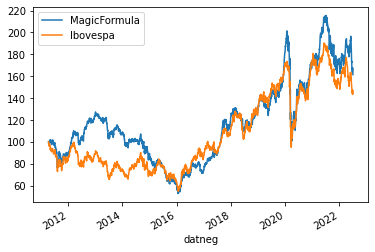

In [15]:
# Simple plot
df_portfolio[['MagicFormula', 'Ibovespa']].plot()

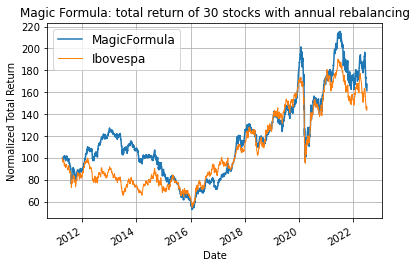

In [16]:
# Adjusted plot
df_portfolio['MagicFormula'].plot(linestyle='-', label='MagicFormula')
df_portfolio['Ibovespa'].plot(linestyle='-', linewidth = '1', label='Ibovespa')
plt.title('Magic Formula: total return of 30 stocks with annual rebalancing')
plt.ylabel('Normalized Total Return')
plt.xlabel('Date')
# plt.yscale('log')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.savefig('../images/magic_ibov.jpg', dpi=300, transparent=False)